<a href="https://colab.research.google.com/github/lars-sandved/pymdp/blob/master/aif_model_of_FA_meditation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title To do:

# encode preference to be aware of breath via likelihood precision of observations of perceptual posterior
# learn more about gamma distributions and inverse temperatures
# add novelty term to EFE
# review the ascending message passing scheme
# implement 3rd meta-awareness states
# implement mindfulness as a 4th level (?) state that drives precise transitions of the meta-awareness of perceptual content (ie keeping in working memory the expectation that meta-awareness remains high, and therefore that the observations of posterior precision remain informative).

In [ ]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#@title Imports and functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from google.colab import files


np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)


def softmax(X):                                                                 ###converts log probabilities to probabilities
  norm = np.sum(np.exp(X)+10**-5)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def softmax_dim2(X):                                                            ###converts matrix of log probabilities to matrix of probabilities
  norm = np.sum(np.exp(X)+10**-5,axis=0)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def normalise(X):                                                               ###normalises a matrix of probabilities
  X= X/np.sum(X,0)
  return X

def NormalizeData(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

def dot(a,b):
  c = np.array([a[0,0]*b[0]+a[1,0]*b[1]+a[2,0]*b[2]+a[3,0]*b[3] , a[0,1]*b[0]+a[1,1]*b[1]+a[2,1]*b[2]+a[3,1]*b[3]])
  return c

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
#@title Defining generative processes of the breath
T = 40

# True state of breath
x1 = np.zeros(T)                                                                ### 10 phases of the breath 0 = bottom of exhale, 5 = top of inhale. Breath starts at bottom of exhale

# Breath state transitions b1 = p(x(t+1)|x(t))
b1 = np.zeros((10,10))
for i in range(9):
    b1[i+1,i] = 1
b1[0,9]=1

# Evolve true states of generative process
for t in range(T):
  if t<T-1:
    x1[t+1] = np.random.choice(np.arange(10),p=b1[:,int(x1[t])])

# Generate outcomes based on generative process
o1 = np.zeros(T)                                                                 ### observations (expansion vs contraction)
for i in range(T):
  if 0 <= x1[i] < 5:                                                            ### during the inhale phase, observation is 0, 'expansion'
    o1[i] = 0
  else:                                                                         ### during the exhale phase, observation is 1, 'contraction'
    o1[i] = 1

# Level 2                                                                       ### generative process of 'breath awareness' - meditator is aware of the breath if the posterior distribution on the perceptual level, X1, has some structure. ie. if the beliefs pass some perceptual threshold.

x2_attention = np.zeros(T)                                                  ### initialise true states of attention 0 = focused, 1 = distracted
x2_breath_awareness = np.zeros(T)                                           ## 'breath awareness' state - 0 aware  vs 1 not aware
perceptual_threshold = 0.65                                                     ### defines when the breath can be said to be perceived

(0.5, 40.5)

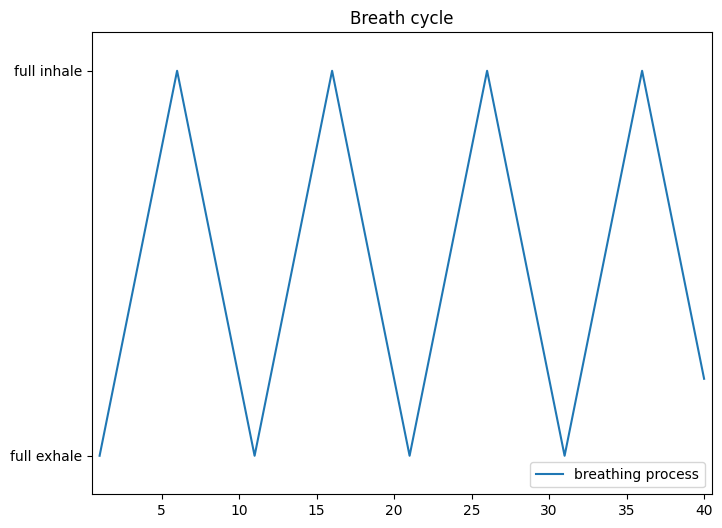

In [ ]:
#@title Plotting the external gen. process (breathing)

# Create plot friendly x1 (mirrored at top of inhale)

x1plt = x1
x1plt = np.where(x1plt == 6, 4,x1plt)
x1plt = np.where(x1plt == 7, 3,x1plt)
x1plt = np.where(x1plt == 8, 2,x1plt)
x1plt = np.where(x1plt == 9, 1,x1plt)

x1plt = NormalizeData(x1plt)

plt.figure(figsize=(8,6))

plt.plot(1+np.arange(0,T),x1plt[:],label='breathing process')
plt.legend(loc = 'lower right')
plt.ylim(-0.1,1.1)
plt.yticks([0,1],['full exhale','full inhale'])
#plt.ylabel(r'$\pi^{(2)}$')
plt.title('Breath cycle')
plt.xlim([0.5,T+0.5])



In [ ]:
#@title Initialisation of Level 1 of the generative model (breath perception)

######## Perceptual level 1 ##########

# Perceptual state beliefs
X1 = np.zeros((2,T))                                                        ### perception prior (breathing in vs breathing out)
X1bar = np.zeros((2,T))                                                     ### perception posterior
X1[:,0] = [0.5,0.5]                                                           ### perceptual state prior at T=0, ie. D1

# Defining the transition matrix
B1 = np.zeros((2,2))                                                        ### generalised transition tensor nX1 state factors with 2 levels each.

B1[0,:]=[0.5,0.5]                                                             ### probablity of transitioning to X1(t+1) = 0 "inhaling" from X1(t) = 0/1
B1[1,:]=[0.5,0.5]                                                             ### probablity of transitioning to X1(t+1) = 1 "exhaling" from X1(t) = 0/1

# Defining the likelihood matrix
A1 = np.zeros((2, 2))                                                      ### initialisation of likelihood tensor for nX1 state factors
A1bar = np.zeros((2, 2))                                                   ### initialisation of precision weighted likelihood mapping

# breath sensation modality
A1[0,:] = [0.75,0.25]                                                         ### likelihood of observing 01 = 0 "expansion" given X1(breath) = inhaling/exhaling
A1[1,:] = [0.25,0.75]                                                         ### likelihood of observing 01 = 1 "contraction" given X1(breath) = inhaling/exhaling
gammaA1 = np.zeros((T))                                                    ### the likelihood precision
betaA1m = np.array([0.25,4.0])                                                  ### inverse precision


# Observations
O1 = np.zeros((2,T))                                                        ### observation prior (expansion vs contraction)
for t in range(T):
  O1[int(o1[t]),t]=1                                                        ### observations are based on generative process of breathing


print_flag = 0
if print_flag == 1:
  print("Matrices defined for level 1 perception:")
  print("Hidden states X1")
  print(X1)
  print("Likelihood matrix A1")
  print(A1)
  print("Transition matrix B1")
  print(B1)
  print("Observations 01")
  print(O1)

In [ ]:
#@title Initialisation of Level 2 of the generative model (attention & breath awareness)

######## Mental level 2 ##########

Pi2 = np.zeros((2,T))                                                           ### prior attentional actions (stay, switch)
Pi2bar = np.zeros((2,T))                                                        ### posterior attentional actions (stay, switch)
u2 = np.zeros(T)                                                                ### true actions (gen. process)

E2 = np.array([1,1])                                                      ### prior over attentional policies
gammaG2 = 2.0
C2 = np.array([0,0,2,0])                                                 ### preference over outcomes (prefer to be aware of breath)
C2 = C2 + 1e-10
X2_attention = np.zeros((2,T))                                                  ### second level states prior (attention 0 = focused, 1 = distracted)
X2bar_attention = np.zeros((2,T))                                               ### secdon level states posterior
X2_attention[:,0] = [0.5,0.5]                                                   ### attentional state factor prior D2

X2_breath_awareness = np.zeros((2,T))
X2bar_breath_awareness = np.zeros((2,T))
X2_breath_awareness[:,0] = [0.5,0.5]

O2 = np.zeros((4,T))

# Defining likelihood matrix
A2_attention = np.zeros((4,2))                                                  # random initialisation of attentional perceptual model (this is what the meditator needs to learn - ie. how does my sensory precision relate to attentional states?)
# observations from attentional state are noisy
A2_attention[0,:] = [.3,0.2]                                                   # attentional states begin transparent
A2_attention[1,:] = [0.2,.3]
# observations from breath perception are precise
A2_attention[2,:] = [.49,0.01]                                                  # the instructions endow the belief that awareness of breath has some mapping to my attention.
A2_attention[3,:] = [0.01,.49]

A2bar_attention = np.zeros((4,2))                                                  # random initialisation of attentional perceptual model (this is what the meditator needs to learn - ie. how does my sensory precision relate to attentional states?)
gammaA2_attention = np.ones((T))                                                          ### A2 precision set to one (no meta-awareness level for now)

A2_breath_awareness = np.zeros((4,2))
A2_breath_awareness[0,:] = [.45,.05]                                                        ### likelihood of attentional states given observations of breath perception
A2_breath_awareness[1,:] = [.05,.45]
A2_breath_awareness[2,:] = [.49,0.01]                                                          ### likelihood of awareness of breath states given observations of breath perception
A2_breath_awareness[3,:] = [0.01,.49]

A2bar_breath_awareness = np.zeros((4,2))
gammaA2_breath_awareness = np.ones((T))                                                          ### A2 precision set to one (no meta-awareness level for now)

betaA2m = np.array([0.5,2.0])

# Defining the transition matrix
B2_breath_awareness = np.zeros((2,2))
B2_breath_awareness[0,:]=[0.7,0.3]
B2_breath_awareness[1,:]=[0.3,0.7]

# Defining the transition matrix
B2a = np.zeros((2,2))                                                           ### maintain attentional state - "stay"
B2b = np.zeros((2,2))                                                           ### switch atttentional state - "switch"

B2a[0,:]=[.8,0]                                                               ###probability of focus/distracted, given focus+stay
B2a[1,:]=[.2,1]                                                              ###probability of focus/distracted, given distracted+stay

B2b[0,:]=[0.0,1.0]                                                              ###probability of focus/distracted, given focus+switch
B2b[1,:]=[1.0,0.0]                                                              ###probability of focus/distracted, given distracted+switch

# ######## Setting up F & G calculations #######

A = np.squeeze(np.asarray(A2_attention))
H = np.zeros(2)
# calculate -diag(A_transpose.log(A)) for ambiguity term in G
H[0] = np.dot(np.transpose(A),np.log(A))[0,0]
H[1] = np.dot(np.transpose(A),np.log(A))[1,1]

G = np.zeros((2,T))
gammaG = 2.0
F = np.zeros((2,T))

print_flag = 0
if print_flag == 1:
  print("Matrices defined for level 2 :")
  print("Hidden attentional states X2_attention")
  print(X2_attention)
  print("Hidden awareness of breath states X2_breath_awareness")
  print(X2_breath_awareness)
  print("Likelihood matrix for attentional state A2_attention")
  print(A2_attention)
  print("Likelihood matrix for breath awareness state A2_breath_awareness")
  print(A2_breath_awareness)
  print("Transition matrix B2a")
  print(B2a)
  print("Transition matrix B2b")
  print(B2b)
  print("Transition matrix B2_breath_awareness")
  print(B2_breath_awareness)
  print("Observations 02")
  print(O2)

In [ ]:
#@title Simulate single trial

for t in range(T):

  ### State belief updating

  ### perceptual level X1
  gammaA1[t] = betaA1m[int(x2_attention[t])]**-1                                ### actual precision is based on generative process (earlier it was betaA1**-1)
  A1bar[:,:] = softmax_dim2(np.log(A1[:,:])*gammaA1[t])                         ### Precision weighted likelihood mapping
  X1bar[:,t] = softmax(np.log(X1[:,t])+np.log(A1bar[int(O1[0,t]),:]))           ## calculate perceptual state posterior
  # to do: add precision inference

  # generate observations at second level from true states (gen. process)
  # attentional observations
  O2[0,t] = 1 - x2_attention[t]
  O2[1,t] = x2_attention[t]
  # awareness of breath observations
  # to do: change this to a precision inference on the perceptual posterior passed through a likelihood mapping
  if np.max(X1bar[:,t]) > perceptual_threshold:
    x2_breath_awareness[t] = 0          # aware of the breath
  else:
    x2_breath_awareness[t] = 1          # not aware the breath
  O2[2,t] = 1 - x2_breath_awareness[t]
  O2[3,t] = x2_breath_awareness[t]

  ## calculate attentional state posterior given precision beliefs
  A2bar_attention = softmax_dim2(np.log(A2_attention)*gammaA2_attention[t])     ### precision weighted likelihood mapping
  X2bar_attention[:,t] = softmax(np.log(X2_attention[:,t]) + np.log(dot(A2bar_attention,O2[:,t])))

  A2bar_breath_awareness = softmax_dim2(np.log(A2_breath_awareness)*gammaA2_breath_awareness[t])     ### precision weighted likelihood mapping
  X2bar_breath_awareness[:,t] = softmax(np.log(X2_breath_awareness[:,t]) + np.log(dot(A2bar_breath_awareness,O2[:,t])))

  ### Policy selection

  if t<(T-1):
    # for controlable attentional state
    # calculate action specific priors and observation for next time step
    X2a = np.inner(B2a,X2bar_attention[:,t])
    O2a = np.inner(A2_attention,X2a)

    X2b = np.inner(B2b,X2bar_attention[:,t])
    O2b = np.inner(A2_attention,X2b)

    # calculate expected free-energy
    G[0,t] = np.dot(O2a,(np.log(O2a)-np.log(softmax(C2))))-np.dot(X2a,H)
    G[1,t] = np.dot(O2b,(np.log(O2b)-np.log(softmax(C2))))-np.dot(X2b,H)

    # prior over policies
    Pi2[:,t] = softmax(np.log(E2)-gammaG2*G[:,t])

    # transition model given policy priors
    B2_attention = B2a*Pi2[0,t]+B2b*Pi2[1,t]

    # evolve expected states
    X2_attention[:,t+1] = np.inner(B2_attention,X2bar_attention[:,t])                             # second level attentional state prior for next timestep
    X2_breath_awareness[:,t+1] = np.inner(B2_breath_awareness,X2bar_breath_awareness[:,t])        # second level awareness of breath state prior for next timestep
    X1[:,t+1] = np.inner(B1,X1bar[:,t])                                                           # first level perceptual state prior for next timestep

    # evolve generative process (discrete)
    # true next actions
    u2[t] = np.arange(2)[np.argmax(Pi2[:,t])]

    # true next attentional state
    if u2[t]==0:
      x2_attention[t+1] = np.random.choice([0,1],p=B2a[:,int(x2_attention[t])])                   ###generate true state from action 0
    else:
      x2_attention[t+1] = np.random.choice([0,1],p=B2b[:,int(x2_attention[t])])                   ###generate true state from action 1

    # calculate FE under each action
    if t>0:
      # calculate action specific posteriors
      X2abar = softmax(np.log(X2a)+np.log(dot(A2bar_attention,O2[:,t-1])))
      X2bbar = softmax(np.log(X2b)+np.log(dot(A2bar_attention,O2[:,t-1])))

      # calculate FE
      F[0,t-1] = np.dot(X2abar,(np.log(X2abar)-np.log(np.inner(B2a,X2bar_attention[:,t-1]))-np.log(A2_attention[int(x2_attention[t-1]),:])))
      F[1,t-1] = np.dot(X2bbar,(np.log(X2bbar)-np.log(np.inner(B2b,X2bar_attention[:,t-1]))-np.log(A2_attention[int(x2_attention[t-1]),:])))

      # calculate policy posterior given perceptual evidence
      Pi2bar[:,t-1]=softmax(np.log(E2)-gammaG2*G[:,t-1]-F[:,t-1])

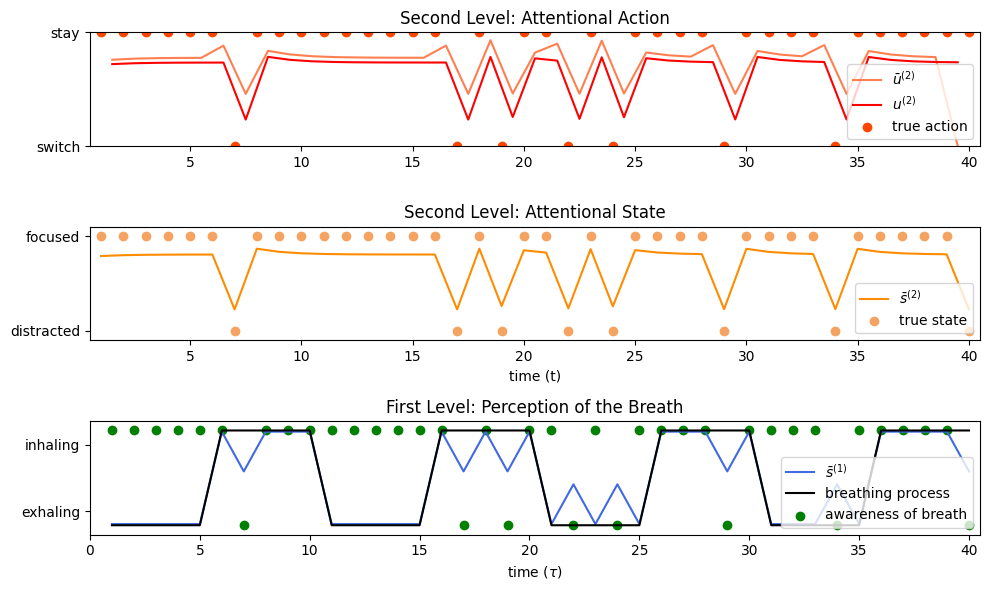

In [ ]:
#@title Plotting results for single trial

plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
#plt.plot(1.5+np.arange(0,T-1),Pi2[0,:-1],label='stay (prior)',linestyle='--')
#plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (prior')
plt.plot(1.5+np.arange(0,T-1),Pi2bar[0,:-1],label=r'${\bar{u}}^{(2)}$',color='coral')
plt.plot(1.5+np.arange(0,T-1),Pi2[0,:-1],label=r'${u}^{(2)}$',color='red')

#plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (posterior)',linestyle='--')
plt.scatter(1+np.arange(T),1-u2,label='true action',color='orangered')
plt.legend(loc = 'lower right')
plt.ylim([0,1.0])
plt.yticks([0,1],['switch','stay'])
#plt.ylabel(r'$\pi^{(2)}$')
plt.title('Second Level: Attentional Action')
plt.xlim([0.5,T+0.5])

plt.subplot(3,1,2)
#plt.plot(1+np.arange(T),X2[0,:],label=r'${x}^{(2)}$',linestyle='--')
plt.plot(1+np.arange(T),X2bar_attention[0,:],label=r'${\bar{s}}^{(2)}$',color='darkorange')
plt.scatter(1+np.arange(T),1-x2_attention,label='true state',color='sandybrown')
#plt.imshow([0.5*(1-0.5*x2),0.5*(1-0.5*x2)], aspect='auto',cmap='gray',alpha=0.3,extent=[0.5,100.5,-0.3,1.3])
#plt.plot(X2bar[1,:],label='distracted')
plt.ylim([-0.1,1.1])
plt.yticks([0,1],['distracted','focused'])
plt.xlabel('time (t)')
#plt.ylabel(r'$x^{(2)}$')
plt.title('Second Level: Attentional State')
plt.legend(loc = 'lower right')
plt.xlim([0.5,T+0.5])

plt.subplot(3,1,3)
plt.plot(1+np.arange(T),X1bar[0,:],label=r'${\bar{s}}^{(1)}$',color='royalblue')
plt.plot(1+np.arange(0,T),o1[:],label='breathing process',color='black')
plt.scatter(1+np.arange(T),1-x2_breath_awareness,label='awareness of breath',color='green')

plt.yticks([0.15,.85],['exhaling','inhaling'])
plt.xlabel(r'time ($\tau$)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('First Level: Perception of the Breath')
plt.legend(loc = 'lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,T+0.5])

plt.tight_layout()
# plt.savefig("figure_11.tiff", dpi = 600)
# files.download("figure_11.tiff")

In [ ]:
#@title Simulate learning over multiple trials
number_of_trials = 120

# Parameters required for learning
learning_rate = .5
forgetting_rate = .8

# Saving the liklihood mappings
A_matrices = np.zeros((number_of_trials,4,2))
I = np.identity(2)
I = I + 1e-10
KL_div = np.zeros(number_of_trials)


# reset likelihood mapping
A2_attention = np.zeros((4,2))                                                  # random initialisation of attentional perceptual model (this is what the meditator needs to learn - ie. how does my sensory precision relate to attentional states?)
# observations from attentional state are noisy
A2_attention[0,:] = [.3,0.2]                                                   # attentional states begin transparent
A2_attention[1,:] = [0.2,.3]
# observations from breath perception are precise
A2_attention[2,:] = [.49,0.01]                                                      # the instructions endow the belief that awareness of breath has some mapping to my attention.
A2_attention[3,:] = [0.01,.49]

for tr in range(number_of_trials):
  print("Trial ",tr)
  print("A2_attention:")
  print(A2_attention)

  # print("Determinant:", np.linalg.det(A2_attention[0:2,:]))
  # print("Condition number: ", np.linalg.cond(A2_attention[0:2,:]))
  # print("Singular values: ", np.linalg.svd(A2_attention[0:2,:])[1])

  # reset gen process
  O2 = np.zeros((4,T))

  for t in range(T):

    ### State belief updating

    ### perceptual level X1
    gammaA1[t] = betaA1m[int(x2_attention[t])]**-1                                ### actual precision is based on generative process (earlier it was betaA1**-1)
    A1bar[:,:] = softmax_dim2(np.log(A1[:,:])*gammaA1[t])                         ### Precision weighted likelihood mapping
    X1bar[:,t] = softmax(np.log(X1[:,t])+np.log(A1bar[int(O1[0,t]),:]))           ## calculate perceptual state posterior
    # to do: add precision inference

    # generate observations at second level from true states (gen. process)
    # attentional observations
    O2[0,t] = 1 - x2_attention[t]
    O2[1,t] = x2_attention[t]
    # awareness of breath observations
    # to do: change this to a precision inference on the perceptual posterior passed through a likelihood mapping
    if np.max(X1bar[:,t]) > perceptual_threshold:
      x2_breath_awareness[t] = 0          # aware of the breath
    else:
      x2_breath_awareness[t] = 1          # not aware the breath
    O2[2,t] = 1 - x2_breath_awareness[t]
    O2[3,t] = x2_breath_awareness[t]

    ## calculate attentional state posterior given precision beliefs
    A2bar_attention = softmax_dim2(np.log(A2_attention)*gammaA2_attention[t])     ### precision weighted likelihood mapping
    X2bar_attention[:,t] = softmax(np.log(X2_attention[:,t]) + np.log(dot(A2bar_attention,O2[:,t])))

    A2bar_breath_awareness = softmax_dim2(np.log(A2_breath_awareness)*gammaA2_breath_awareness[t])     ### precision weighted likelihood mapping
    X2bar_breath_awareness[:,t] = softmax(np.log(X2_breath_awareness[:,t]) + np.log(dot(A2bar_breath_awareness,O2[:,t])))

    ### Policy selection

    if t<(T-1):
      # for controlable attentional state
      # calculate action specific priors and observation for next time step
      X2a = np.inner(B2a,X2bar_attention[:,t])
      O2a = np.inner(A2_attention,X2a)

      X2b = np.inner(B2b,X2bar_attention[:,t])
      O2b = np.inner(A2_attention,X2b)

      # calculate expected free-energy
      G[0,t] = np.dot(O2a,(np.log(O2a)-np.log(softmax(C2))))-np.dot(X2a,H)
      G[1,t] = np.dot(O2b,(np.log(O2b)-np.log(softmax(C2))))-np.dot(X2b,H)

      # prior over policies
      Pi2[:,t] = softmax(np.log(E2)-gammaG2*G[:,t])

      # transition model given policy priors
      B2_attention = B2a*Pi2[0,t]+B2b*Pi2[1,t]

      # evolve expected states
      X2_attention[:,t+1] = np.inner(B2_attention,X2bar_attention[:,t])                             # second level attentional state prior for next timestep
      X2_breath_awareness[:,t+1] = np.inner(B2_breath_awareness,X2bar_breath_awareness[:,t])        # second level awareness of breath state prior for next timestep
      X1[:,t+1] = np.inner(B1,X1bar[:,t])                                                           # first level perceptual state prior for next timestep

      # evolve generative process (discrete)
      # true next actions
      u2[t] = np.arange(2)[np.argmax(Pi2[:,t])]

      # true next attentional state
      if u2[t]==0:
        x2_attention[t+1] = np.random.choice([0,1],p=B2a[:,int(x2_attention[t])])                   ###generate true state from action 0
      else:
        x2_attention[t+1] = np.random.choice([0,1],p=B2b[:,int(x2_attention[t])])                   ###generate true state from action 1

      # calculate FE under each action
      if t>0:
        # calculate action specific posteriors
        X2abar = softmax(np.log(X2a)+np.log(dot(A2bar_attention,O2[:,t-1])))
        X2bbar = softmax(np.log(X2b)+np.log(dot(A2bar_attention,O2[:,t-1])))

        # calculate FE
        F[0,t-1] = np.dot(X2abar,(np.log(X2abar)-np.log(np.inner(B2a,X2bar_attention[:,t-1]))-np.log(A2_attention[int(x2_attention[t-1]),:])))
        F[1,t-1] = np.dot(X2bbar,(np.log(X2bbar)-np.log(np.inner(B2b,X2bar_attention[:,t-1]))-np.log(A2_attention[int(x2_attention[t-1]),:])))

        # calculate policy posterior given perceptual evidence
        Pi2bar[:,t-1]=softmax(np.log(E2)-gammaG2*G[:,t-1]-F[:,t-1])

  # plot results
  plot_flag = 0

  if plot_flag == 1:

    plt.figure(figsize=(10,6))

    plt.subplot(3,1,1)
    #plt.plot(1.5+np.arange(0,T-1),Pi2[0,:-1],label='stay (prior)',linestyle='--')
    #plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (prior')
    plt.plot(1.5+np.arange(0,T-1),Pi2bar[0,:-1],label=r'${\bar{u}}^{(2)}$',color='coral')
    plt.plot(1.5+np.arange(0,T-1),Pi2[0,:-1],label=r'${u}^{(2)}$',color='red')

    #plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (posterior)',linestyle='--')
    plt.scatter(1+np.arange(T),1-u2,label='true action',color='orangered')
    plt.legend(loc = 'lower right')
    plt.ylim([0,1.0])
    plt.yticks([0,1],['switch','stay'])
    #plt.ylabel(r'$\pi^{(2)}$')
    plt.title('Second Level: Attentional Action')
    plt.xlim([0.5,T+0.5])

    plt.subplot(3,1,2)
    #plt.plot(1+np.arange(T),X2[0,:],label=r'${x}^{(2)}$',linestyle='--')
    plt.plot(1+np.arange(T),X2bar_attention[0,:],label=r'${\bar{s}}^{(2)}$',color='darkorange')
    plt.scatter(1+np.arange(T),1-x2_attention,label='true state',color='sandybrown')
    #plt.imshow([0.5*(1-0.5*x2),0.5*(1-0.5*x2)], aspect='auto',cmap='gray',alpha=0.3,extent=[0.5,100.5,-0.3,1.3])
    #plt.plot(X2bar[1,:],label='distracted')
    plt.ylim([-0.1,1.1])
    plt.yticks([0,1],['distracted','focused'])
    plt.xlabel('time (t)')
    #plt.ylabel(r'$x^{(2)}$')
    plt.title('Second Level: Attentional State')
    plt.legend(loc = 'lower right')
    plt.xlim([0.5,T+0.5])

    plt.subplot(3,1,3)
    plt.plot(1+np.arange(T),X1bar[0,:],label=r'${\bar{s}}^{(1)}$',color='royalblue')
    plt.plot(1+np.arange(0,T),o1[:],label='breathing process',color='black')
    plt.scatter(1+np.arange(T),1-x2_breath_awareness,label='awareness of breath',color='green')

    plt.yticks([0.15,.85],['exhaling','inhaling'])
    plt.xlabel(r'time ($\tau$)')
    # plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
    plt.title('First Level: Perception of the Breath')
    plt.legend(loc = 'lower right')
    plt.ylim([-0.1,1.1])
    plt.xlim([0,T+0.5])

    plt.tight_layout()

  # A matrix learning at end of trial

  # normalize observations
  O2 = normalize(O2, axis = 0 , norm ='l1')

  # A1 likelihood matrix learning
  sum_of_coincidences = np.zeros((4,2))                                         ## sum coincidences of observations and inferred states
  for t in range(T):
    coincidence_t = np.outer(O2[:,t],X2bar_attention[:,t])
    sum_of_coincidences = sum_of_coincidences + coincidence_t

  A2_attention[0,0] = forgetting_rate * A2_attention[0,0] + learning_rate * sum_of_coincidences[0,0]
  A2_attention[1,0] = forgetting_rate * A2_attention[1,0] + learning_rate * sum_of_coincidences[1,0]
  A2_attention[2,0] = forgetting_rate * A2_attention[2,0] + learning_rate * sum_of_coincidences[2,0]
  A2_attention[3,0] = forgetting_rate * A2_attention[3,0] + learning_rate * sum_of_coincidences[3,0]
  A2_attention[0,1] = forgetting_rate * A2_attention[0,1] + learning_rate * sum_of_coincidences[0,1]
  A2_attention[1,1] = forgetting_rate * A2_attention[1,1] + learning_rate * sum_of_coincidences[1,1]
  A2_attention[2,1] = forgetting_rate * A2_attention[2,1] + learning_rate * sum_of_coincidences[2,1]
  A2_attention[3,1] = forgetting_rate * A2_attention[3,1] + learning_rate * sum_of_coincidences[3,1]

  A2_attention = normalize(A2_attention, axis = 0, norm ='l1')
  # save A matrix
  A_matrices[tr] = A2_attention
  KL_div[tr] = kl_divergence(A2_attention[0:2,:],I)
  print("KL_divergence:",KL_div[tr])

  # determinant[tr] = np.linalg.det(A2_attention[0:2,:])
  # condition_number[tr] = np.linalg.cond(A2_attention[0:2,:])
  # singular_values[:,tr] =  np.linalg.svd(A2_attention[0:2,:])[1]


In [ ]:
#@title Plot KL divergence between A_attention and Identity over trials
plt.figure(figsize=(10,6))
plt.plot(1.5+np.arange(0,number_of_trials),KL_div,label=r'${\bar{u}}^{(2)}$',color='coral')
# plt.plot(1.5+np.arange(0,number_of_trials),determinant,label=r'${\bar{u}}^{(2)}$',color='blue')
plt.tight_layout()

Text(0, 0.5, 'Y')

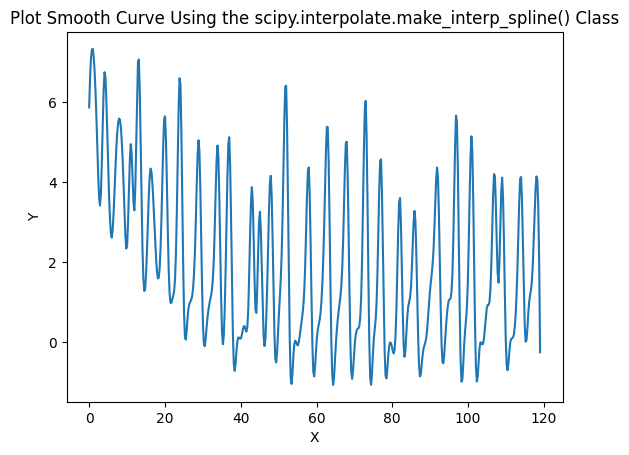

In [ ]:
from scipy.interpolate import make_interp_spline

# Dataset
x = np.arange(0,number_of_trials)
y = KL_div

X_Y_Spline = make_interp_spline(x, y)

# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

# Plotting the Graph
plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")


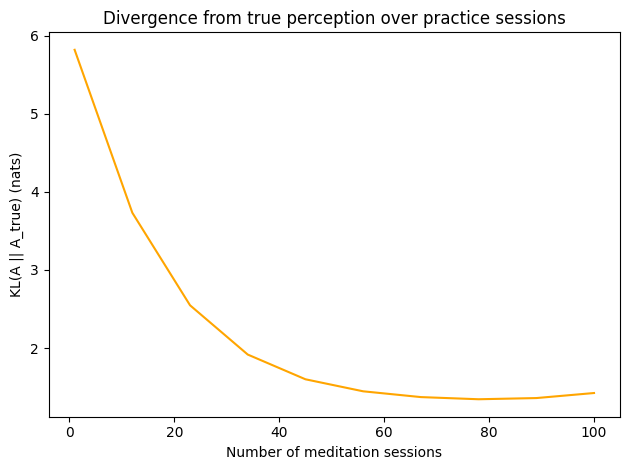

In [ ]:
#fit polynomial models up to degree 5
model1 = np.poly1d(np.polyfit(x, y, 1))
model2 = np.poly1d(np.polyfit(x, y, 2))
model3 = np.poly1d(np.polyfit(x, y, 3))
model4 = np.poly1d(np.polyfit(x, y, 4))
model5 = np.poly1d(np.polyfit(x, y, 5))

#create scatterplot
polyline = np.linspace(1, 100, 10)
# plt.scatter(x, y)

#add fitted polynomial lines to scatterplot
# plt.plot(polyline, model1(polyline), color='green')
# plt.plot(polyline, model2(polyline), color='red')
# plt.plot(polyline, model3(polyline), color='purple')
# plt.plot(polyline, model4(polyline), color='blue')
plt.plot(polyline, model5(polyline), color='orange')
plt.xlabel('Number of meditation sessions')
plt.ylabel('KL(A || A_true) (nats)')
plt.title('Divergence from true perception over practice sessions')
plt.tight_layout()

plt.savefig("kl_div_A.tiff", dpi = 300)
# files.download("kl_div_A.tiff")
plt.show()


In [ ]:

model = np.poly1d(np.polyfit(df.x, df.y, 3))

#add fitted cubic regression line to scatterplot
polyline = np.linspace(1, 60, 50)
plt.scatter(df.x, df.y)
plt.plot(polyline, model(polyline))

#add axis labels
plt.xlabel('x')
plt.ylabel('y')

#display plot
plt.show()

In [ ]:
################################################################################
### Running the simulation over multiple trials
################################################################################
number_of_trials = 5

### Parameters required for learning
learning_rate = 2                                                               # "This controls how quickly it gets ‘stuck in its ways’ during learning
                                                                                # (this also influences how quickly the agent ceases to select information-seeking policies)"
forgetting_rate = .8                                                            # "This parameter controls how strongly recent experience is able to ‘overwrite’ what one has learned in the more distant past. A value of ω = 1 indicates no forgetting
                                                                                # (i.e., recent experience is unable to overwrite what has been learned previously), while values less than 1 allow increasing levels of forgetting (essentially,
                                                                                # with each new observation the agent becomes less confident in what it has previously learned)."
for tr in range(number_of_trials):

  #reset inferences
  ######## Perceptual level 1 ##########
  nX1 = 1                                                                         ### number of state factors at first level (ie. state of breath)
  nO1 = 1                                                                         ### number of observation modalities at the first level (ie. sensations of breath)

  # Perceptual state beliefs
  X1 = np.zeros((nX1,2,T))                                                        ### perception prior (breathing in vs breathing out)
  X1bar = np.zeros((nX1,2,T))                                                     ### perception posterior
  X1[0,:,0] = [0.5,0.5]

  ######## Mental level 2 ##########

  nX2 = 2                                                                         ### number of state factors at first level (ie. attention & awareness of breath)
  nO2 = 2                                                                         ### number of observation modalities at the first level (ie. sensory precision & perceptual precision)

  Pi2 = np.zeros((2,T))                                                           ### prior attentional actions (stay, switch)
  Pi2bar = np.zeros((2,T))                                                        ### posterior attentional actions (stay, switch)

  E2 = np.array([0.99,0.50])                                                      ### prior over attentional policies
  gammaG2 = 2.0
  C2 = np.array([2,-2])                                                            ### preference over attentional outcomes

  X2 = np.zeros((nX2,2,T))                                                        ### second level states prior (attention & breath awareness)
  X2bar = np.zeros((nX2,2,T))                                                     ### secdon level states posterior
  X2[0,:,0] = [0.5,0.5]                                                           ### attentional state factor prior D2
  X2[1,:,0] = [0.5,0.5]                                                           ### breath awareness state factor prior D2

  # determine initial true states x2 at t=0
  x2[0,0] = 0                                                                     ### attentional state factor starts in a focused state
  x2[1,0] = 0                                                                     ### breath awareness state factor starts in aware state

  u2 = np.zeros(T)                                                                ### discrete generative process active states --> u2 sets transition probabilities for x2


  for t in range(T):
    ### State belief updating
    ### attention X2
    A2_attention_bar = softmax_dim2(np.log(A2_attention)*gammaA2[0,t])          ### precision weighted likelihood mappying
    betaA1 = np.sum(betaA1m*np.inner(A2_attention_bar,X2[0,:,t]))               ### Bayesian model average (prior precision beliefs)

    gammaA1[0,t] = betaA1m[int(x2[0,t])]**-1                                    ### actual precision is based on generative process (earlier it was betaA1**-1)

    ### perceptual level X1
    A1bar[0,:,:] = softmax_dim2(np.log(A1[0,:,:])*gammaA1[0,t])                 ### Precision weighted likelihood mapping

    X1bar[0,:,t] = softmax(np.log(X1[0,:,t])+np.log(A1bar[0,int(O[t]),:]))      ## calculate perceptual state posterior

    ### calculating ascending message from X1->X2
    AtC = 0                                                                     ### "attentional charge" - inverse precision updating term
    for i in range(2):                                                          ##loop over outcomes
      for j in range(2):                                                        ##loop over states
        AtC += (O1bar[0,i,t]-A1bar[0,i,j])*X1bar[0,j,t]*np.log(A1[0,i,j])       ### See "Uncertainty, epistemics and active inference" Parr, Friston.
    if AtC > betaA1m[0]:
      AtC = betaA1m[0]-10**-5
    betaA1bar = betaA1 - AtC                                                    ## inverse precision posterior

    ## calculate attentional state posterior given precision beliefs
    X2bar[0,:,t] = (softmax(np.log(X2[0,:,t])                                   # prior beliefs term
                    + gammaA2[0,t]*np.log(A2_attention[0,int(x2[0,t]),:])       # perceptual evidence from attentional observation modality
                    + gammaA2[1,t]*np.log(A2_breath[0,int(x2[1,t]),:])          # perceptual evidence from the breath awareness modality
                    -1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))        # ascending evidence from lower level sensory precision
    )

    ### calculate awareness of breath state posterior
    X2bar[1,:,t] = (softmax(np.log(X2[1,:,t])                                   # prior beliefs term
                    + gammaA2[0,t]*np.log(A2_attention[1,int(x2[0,t]),:])       # perceptual evidence from attentional observation modality
                    + gammaA2[1,t]*np.log(A2_breath[1,int(x2[1,t]),:])          # perceptual evidence from the breath awareness modality
                    -1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))        # ascending evidence from lower level sensory precision
    )

    ### Policy selection
    if t<(T-1):

      # for controlable attentional state
      X2a = np.inner(B2a,X2bar[0,:,t])
      O2a = np.inner(A2_attention,X2a)

      X2b = np.inner(B2b,X2bar[0,:,t])
      O2b = np.inner(A2_attention,X2b)

      G2[0,t] = np.sum(O2a*(np.log(O2a)-C2)-X2a*H2)
      G2[1,t] = np.sum(O2b*(np.log(O2b)-C2)-X2b*H2)

      Pi2[:,t] = softmax(np.log(E2)-gammaG2*G2[:,t])

      B2 = B2a*Pi2[0,t]+B2b*Pi2[1,t]

      ###evolve expected states
      # X3[:,t+1] = np.inner(B3,X3bar[:,t])
      X2[0,:,t+1] = np.inner(B2,X2bar[0,:,t])                                   # second level attentional state prior for next timestep
      X2[1,:,t+1] = np.inner(B2_breath,X2bar[1,:,t])                            # second level awareness of breath state prior for next timestep
      X1[0,:,t+1] = np.inner(B1[0],X1bar[0,:,t])                                # first level perceptual state prior for next timestep

      u2[t] = np.arange(2)[Pi2[:,t]==np.amax(Pi2[:,t])]                         ###generative process is discrete

      ### generative process driving attentional states

      # if t<T/2:
      #   x2[0,t+1] = 0 ##set to focused
      # else:
      #   x2[0,t+1] = 1 ##set to distracted

      if u2[t]==0:
        x2[0,t+1] = np.random.choice([0,1],p=B2a[:,int(x2[0,t])])                   ###generate true state from action 0
      else:
        x2[0,t+1] = np.random.choice([0,1],p=B2b[:,int(x2[0,t])])                   ###generate true state from action 1

      ## generative process driving 'awareness of breath' states

      if np.max(X1bar[0,:,t]) > perceptual_threshold:
        x2[1,t+1] = 0          # aware of the breath
      else:
        x2[1,t+1] = 1          # not aware the breath

    X2abar = softmax(np.log(X2a)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
    X2bbar = softmax(np.log(X2b)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))

    if t>0:
      F2[0,t-1] = np.sum(X2abar*(np.log(X2abar)-np.log(A2_attention[int(x2[0,t]),:])-np.log(X2a)))
      F2[1,t-1] = np.sum(X2bbar*(np.log(X2bbar)-np.log(A2_attention[int(x2[0,t]),:])-np.log(X2b)))

      Pi2bar[:,t-1]=softmax(np.log(E2)-gammaG2*G2[:,t-1]-F2[:,t-1])

  ### Between trial learning

  # create observation matrix using true states of attention x2[0]
  O2[1,:] = x2[0]
  for t in range(T):
    if x2[0,t] == 0:
      O2[0,t] = 1
    else:
      O2[0,t] = 0

  # A2[0] attentional likelihood matrix learning
  sum_of_coincidences = np.zeros((2,2))                                         ## sum coincidences of observations and inferred states
  for t in range(T):
    coincidence_t = np.outer(O2[:,t],X2bar[0,:,t])
    sum_of_coincidences = sum_of_coincidences + coincidence_t

  A2_attention[0,0,0] = forgetting_rate * A2_attention[0,0,0] + learning_rate * sum_of_coincidences[0,0]
  A2_attention[0,0,1] = forgetting_rate * A2_attention[0,0,1] + learning_rate * sum_of_coincidences[0,1]
  A2_attention[0,1,0] = forgetting_rate * A2_attention[0,1,0] + learning_rate * sum_of_coincidences[1,0]
  A2_attention[0,1,1] = forgetting_rate * A2_attention[0,1,1] + learning_rate * sum_of_coincidences[1,1]

<ipython-input-12-7815b42e2bc5>:81: RuntimeWarning: divide by zero encountered in log
  + gammaA2[1,t]*np.log(A2_breath[1,int(x2[1,t]),:])          # perceptual evidence from the breath awareness modality


IndexError: ignored